In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 10 - Explore Interest Rate / Term Interaction - Model Simplification
Scripts numbered "1X" explore the discrepancy between interactions measured by ALE and SHAP.  In this script, I use tuning parameters from the base model, and create simplified models, including:
  - Reduce number of features
  - Reduce tree depth

I have seen that not all trees in a model show the discrepant behavior, so I keep a fairly high number of trees.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle, importlib
from IPython.display import Image

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
import shap

In [6]:
from PyALE import ale

In [7]:
from interactions_package.interactions_package import ip_plot
ip_plot.plot_defaults()

## Import data

##### Training data

In [8]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [9]:
train_df.shape

(470858, 35)

In [10]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

In [11]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv')) \
    ['feature'].tolist()

##### Iniital model

In [12]:
# Initial model
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

In [13]:
fit_params_base = base_model.get_params()
fit_params_base

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 30,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### Important features

In [14]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

In [15]:
perm_importance_df.head(5)

,features,importance,abs_importance
0,int_rate,0.002943,0.002943
1,term,0.001499,0.001499
2,loan_amnt,0.001165,0.001165
3,annual_inc,0.000931,0.000931
4,sec_app_fico_range_low,0.000711,0.000711


## Functions for Model Simplification
Create models and see if we observe opposite interaction effects for ALE and Shapley for the interest rate and term interactions.  Fit a model, and evaluate SHAP and ALE values.  Fit on a full training data set, evaluate on a sample

##### Fit a model, and get ALE and SHAP values

In [16]:
def model_fit_ale_shap(train_data, eval_data, features, fit_params, 
                   target_feature = 'target',
                   interaction_features = ['int_rate', 'term'],
                   high_int_thresh = 20,
                   random_state=888):
    
    # Get the model
    model = GradientBoostingClassifier(n_estimators = fit_params['n_estimators'],
                                       random_state=random_state)
    model.set_params(**fit_params)
    model.fit(train_data[features], train_data[target_feature])
    
    # Get the ALE data for interest rate and term
    this_ale = ale(X=eval_data[features], model=model, 
                   feature=interaction_features, 
                   plot=False)
    
    # Get SHAP information
    explainer = shap.TreeExplainer(model, feature_names=features)
    shap_interactions =  explainer.shap_interaction_values(eval_data[features])
    
    # Get SHAP for only the interaction of interest
    term_ind = features.index(interaction_features[1])
    int_rate_ind = features.index(interaction_features[0])
    this_shap = pd.concat([eval_data[interaction_features].reset_index(drop=True),
                            pd.DataFrame({'shap': shap_interactions[:,term_ind, int_rate_ind]})],
                           axis=1)
    
    return model, this_ale, this_shap
    

##### Call the above function, with saving, also plot and get linear fit information

In [17]:
def get_analyze_reduced_model(train_data, eval_data, features, fit_params, 
                              target_feature = 'target',
                              interaction_features = ['int_rate', 'term'],
                              random_state=888,
                              outdir = None,
                              outfile_prefix = None,
                              plot_title = None):
    
    # Get the model, and ALE/SHAP info
    model, ale_df, shap_df = model_fit_ale_shap(train_data, eval_data, features, fit_params, 
                                                target_feature, interaction_features, random_state)
    
    # Create the SHAP and ALE plot
    fig = ip_plot.plot_comp_ale_shap(ale_df, shap_df, title=plot_title)
    
    # Do a linear fit to see if the SHAP/ALE have different trends
    lin_fit = pd.concat([ip_plot.ale_lin_reg_info(ale_df, feature_categories = None),
                         ip_plot.shap_lin_reg_info(shap_df, feature_names = interaction_features)],
                        axis=0, keys=['ale', 'shap']) \
        .reset_index()
    
    # Get the 60 vs 36 month term info for SHAP and ALE
    lin_fit['diff'] = lin_fit.iloc[:,-1]  - lin_fit.iloc[:,-2] 
         
    # Save data and plots if applicable
    if outdir is not None:
        with open(outdir.joinpath(outfile_prefix + '_model.pkl'), 'wb') as po:
            pickle.dump(model, po)
        ale_df.columns = ale_df.columns.astype(str)
        ale_df.to_parquet(outdir.joinpath(outfile_prefix + '_ale.parquet'))
        shap_df.to_parquet(outdir.joinpath(outfile_prefix + '_shap.parquet'))
        fig.savefig(outdir.joinpath(outfile_prefix + '_plot.png'), bbox_inches='tight')
        lin_fit.columns = lin_fit.columns.astype(str)
        lin_fit.to_parquet(outdir.joinpath(outfile_prefix + '_lin_fit.parquet'))
    plt.close()
        
    # Return summary information
    return lin_fit[lin_fit['level_1'] == 'prediction'] \
        [['level_0','diff']] \
        .set_index('level_0') \
        .to_dict() \
        ['diff']
    

## Feature Reduction
Start with the top 10 features and reduce from there.

##### Create sub-directory to hold numerous plots

In [18]:
plot_red_folder = Path(setup.temp_path) \
    .joinpath('10_PLOT_FEAT_REDUCE')
plot_red_folder.mkdir(parents=True, exist_ok=True)

##### Reduce features in a loop and save summary information

In [19]:
%%capture
num_feat = [10, 8, 6, 4, 3, 2]
out_res = pd.DataFrame()
for n in num_feat:
    this_feat_list = perm_importance_df['features'].head(n).to_list()
    this_prefix = f'{n:02}'
    red_mod_res = get_analyze_reduced_model(train_df, train_samp_df, 
                                            this_feat_list, fit_params_base,
                                            outdir = plot_red_folder,
                                            outfile_prefix=this_prefix,
                                            plot_title = f'Top {n} Features')
    sum_val = pd.DataFrame({k:[red_mod_res[k]] for k in red_mod_res.keys()})
    sum_val['n'] = n
    sum_val['prefix'] = this_prefix
    out_res = pd.concat([out_res, sum_val], axis=0)

In [20]:
out_res['delta_ale_shap'] = out_res['ale'] - out_res['shap']

In [21]:
out_res.to_csv(Path(setup.temp_path).joinpath('10_REPORT_feature_reduction_loop.csv'), index=False)
out_res

,ale,shap,n,prefix,delta_ale_shap
0,0.104812,-0.105652,10,10,0.210464
0,0.091913,-0.121491,8,08,0.213404
0,0.077158,-0.131009,6,06,0.208167
0,0.029076,-0.095433,4,04,0.124509
0,-0.018995,-0.098502,3,03,0.079507
0,0.000000,-0.088816,2,02,0.088816


##### Show the plots

2


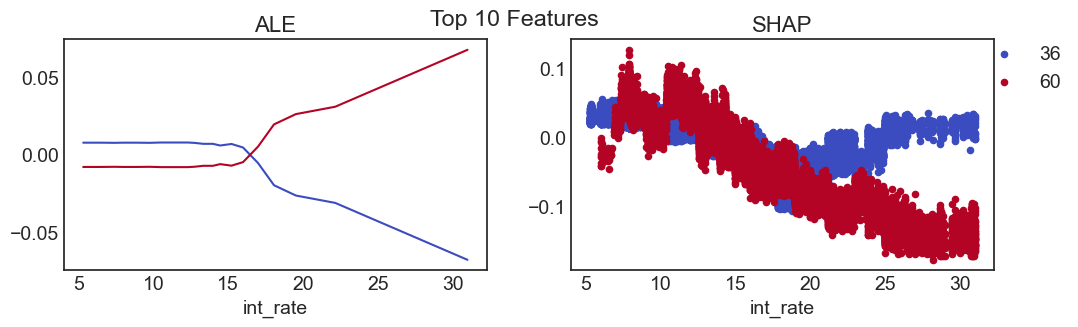

2


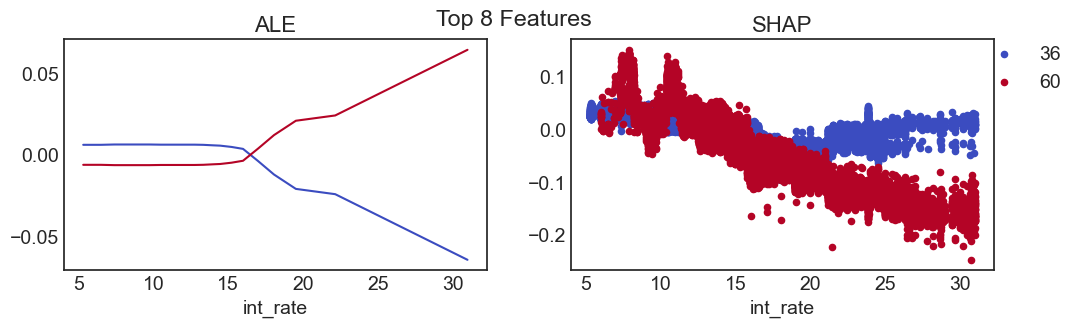

2


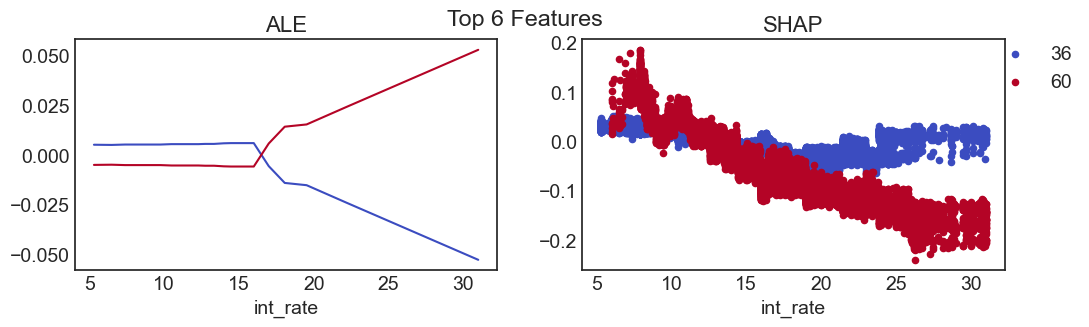

2


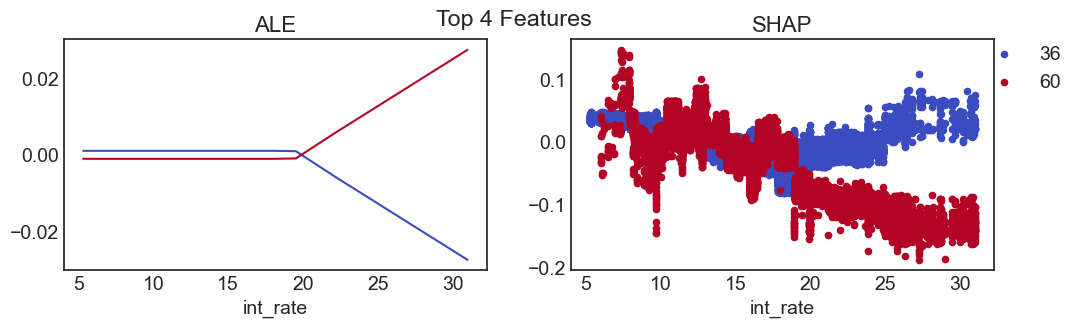

2


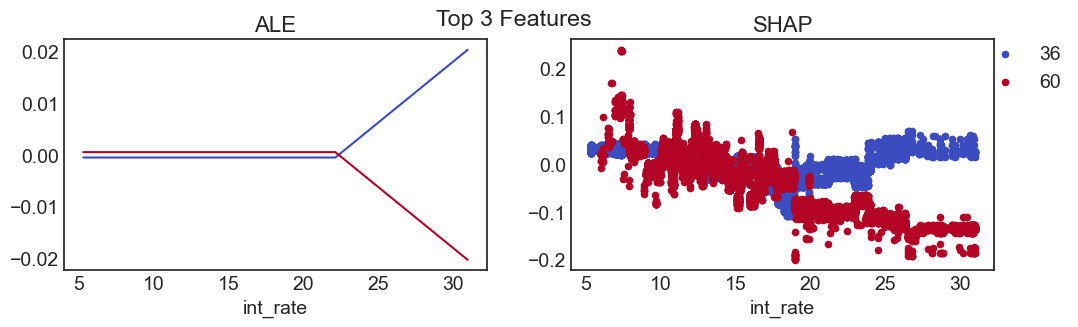

2


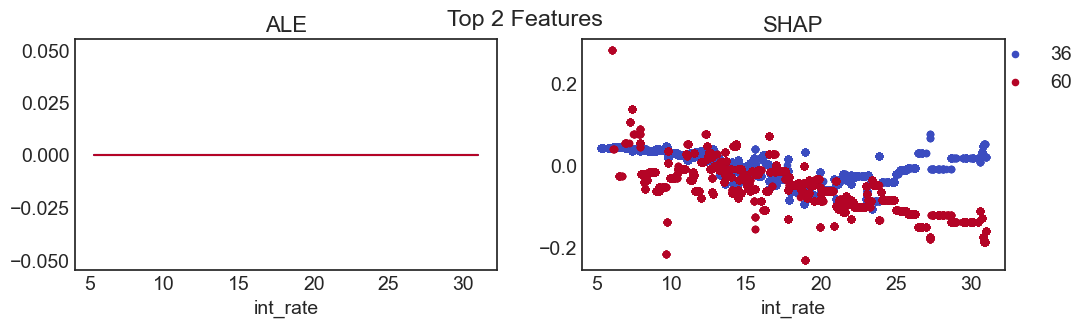

In [22]:
for prefix in out_res['prefix'].to_list():
    print(n)
    display(Image(filename = plot_red_folder.joinpath(f'{prefix}_plot.png')))

Even with a set random seed, results of the fits are not deterministic, so the above may vary.  

The SHAP plots always seem to show their usual general behavior (overlapping curves at low interest rates, then the red 60 month curve keeps decreasign while the blue 36 month curve levels off or increases).

The ALE plots can vary quite a bit run-to-run. For me, the 2-feature curve never shows the discrepant behavior.  SHAP is always flat, or ALE has the same trend as SHAP.

Sometimes the 3-feature plot shows the discrepant behavior but sometimes ALE and SHAP agree.  Once you get to 4+ features, you see the opposing trends in ALE vs. SHAP

The point of divergence seems to be at lower interest rates above 4 features, with the ALE curves showing interactions above maybe 17%.  With fewer features, the point of divergence is more like 22%

## Interest Rate, Term and Annual Income Models
Although the plots above show a 3-way plot with interest rate, term, and loan amount, I have often seen opposing SHAP and ALE  behavior for a 3-feature model containing interest rate, term, and annual income.  I explore models with these 3 features here.

Here I create models using annual income with interest rate and term, and reduce the tree depth.  I use the large-ish number of trees for all models, as I observe that often not all trees show the behavior, and I want to pull out a single simplified tree.  I may get a better simplified tree if I try a lot of trees.

##### Create a folder to hold multiple plots / datasets

In [28]:
plot_3feat_folder = Path(setup.temp_path) \
    .joinpath('10_PLOT_3_FEATURES')
plot_3feat_folder.mkdir(parents=True, exist_ok=True)

##### Loop to explore different tree depths

In [29]:
%%capture
max_depth = [6, 5, 4, 3]

out_res_depth = pd.DataFrame()
for m in max_depth:
    this_prefix = f'{m:02}'
    this_params = fit_params_base.copy()
    this_params['max_depth'] = m
    #this_params['n_estimators'] = 50
    red_mod_res = get_analyze_reduced_model(train_df, train_samp_df, 
                                            ['int_rate', 'term', 'annual_inc'], this_params,
                                            outdir = plot_3feat_folder,
                                            outfile_prefix=this_prefix,
                                            plot_title = f'Max Depth {m}')
    sum_val = pd.DataFrame({k:[red_mod_res[k]] for k in red_mod_res.keys()})
    sum_val['max_depth'] = m
    sum_val['prefix'] = this_prefix
    out_res_depth = pd.concat([out_res_depth, sum_val], axis=0)

In [30]:
out_res_depth['delta_ale_shap'] = out_res_depth['ale'] - out_res_depth['shap']

In [31]:
out_res_depth.to_csv(Path(setup.temp_path).joinpath('10_REPORT_max_depth_loop.csv'), index=False)
out_res_depth

,ale,shap,max_depth,prefix,delta_ale_shap
0,0.003163,-0.085373,6,06,0.088536
0,0.097343,-0.096245,5,05,0.193588
0,0.184062,-0.071370,4,04,0.255431
0,0.246298,-0.044372,3,03,0.290670


##### Show the plots

2


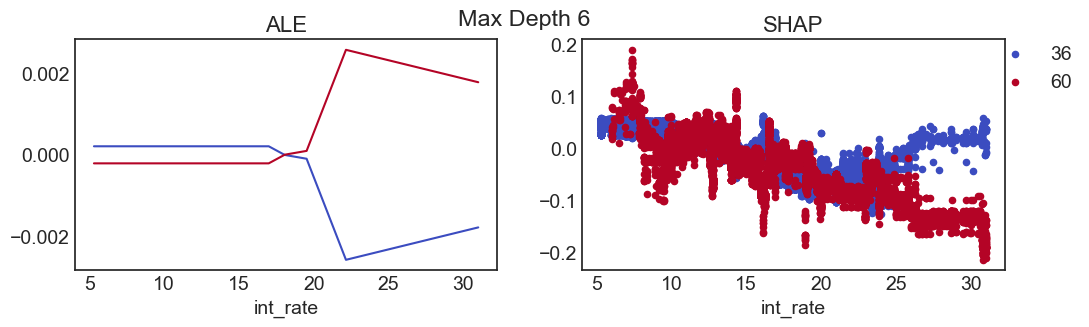

2


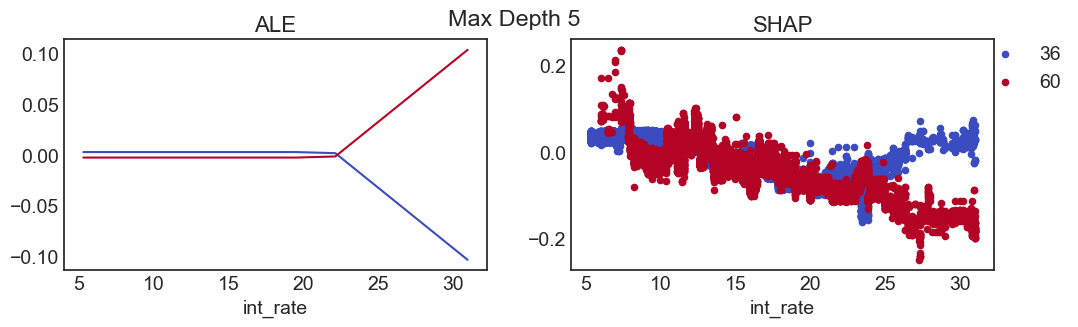

2


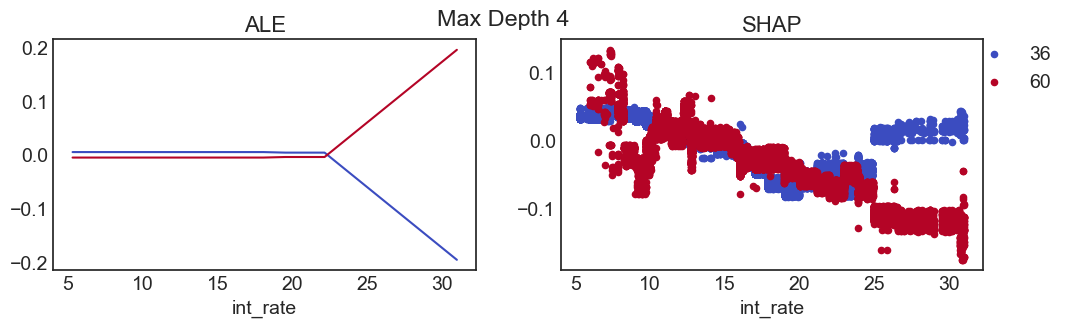

2


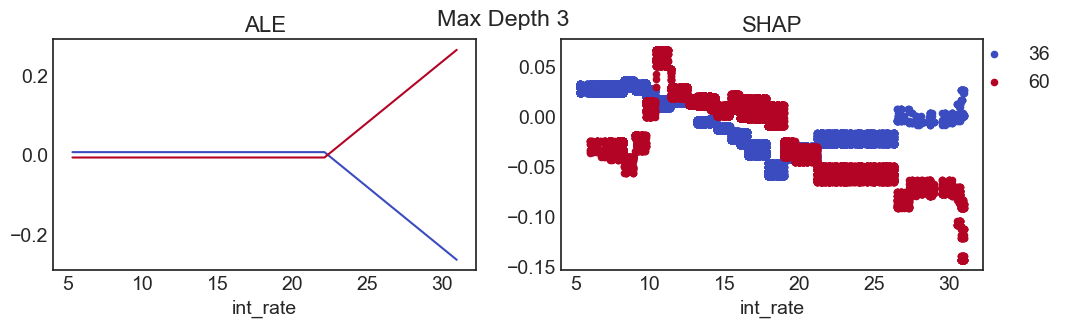

In [32]:
for prefix in out_res_depth['prefix'].to_list():
    print(n)
    display(Image(filename = plot_3feat_folder.joinpath(f'{prefix}_plot.png')))

The above all show the discrepant behavior to some extent.  The lower tree depths show steps in the SHAP plots, which may be expected, and some differences at low interest rate

In the next script, I will pull apart the lower max depth models, and see if individual trees show the opposing behavior